In [1]:
from nnAudio import Spectrogram
from Installation.nnAudio import Spectrogram # Use it during testing

from librosa import filters
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch

In [2]:
# Use cpu if GPU is not found
device='cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Creating a dummy signal for the tests later
# This time we need multiple samples in a batch
# Assume batch size is 512

# We create 511 random waveforms
x = torch.randn(511,220500, device=device)

# create 1 meaningful sine waves
fs = 22050
s = np.linspace(0,10,fs*10)
x_sin = np.sin(2*np.pi*50*s, dtype=np.float32) + np.sin(2*np.pi*100*s, dtype=np.float32) \
    + np.sin(2*np.pi*200*s, dtype=np.float32) + np.sin(2*np.pi*400*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32) \
    + np.sin(2*np.pi*3200*s, dtype=np.float32) + np.sin(2*np.pi*6400*s, dtype=np.float32)

x_sin = torch.tensor(x_sin, device=device).unsqueeze(0)

In [4]:
x = torch.cat((x_sin, x))

# STFT

### nnAudio

In [5]:
spec_layer = Spectrogram.STFT(hop_length=512, n_fft=2048, window='hann'
                                    , freq_scale='no', device=device)

# Using multiple GPU with this nn.DataParallel
spec_layer = torch.nn.DataParallel(spec_layer)

STFT kernels created, time used = 0.2113 seconds


In [6]:
spec = spec_layer(x)

Text(0.5, 1.0, 'nnAudio')

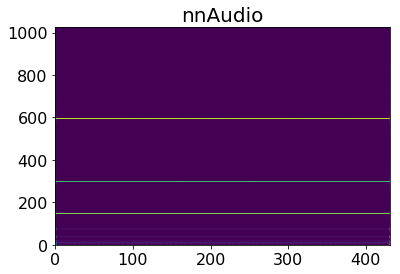

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.imshow(spec[0].cpu().numpy(),aspect='auto', origin='lower')
ax.tick_params(labelsize=16)
ax.set_title('nnAudio', size=20)

# Melspectrogram

### nnAudio

In [8]:
spec_layer = Spectrogram.MelSpectrogram(sr=22050, n_fft=2048, n_mels=128, hop_length=512,
                                        window='hann', center=True, pad_mode='reflect', 
                                        power=2.0, htk=False, fmin=0.0, fmax=None, norm=1, 
                                        verbose=True, device='cuda:0')
# Using multiple GPU with this nn.DataParallel
spec_layer = torch.nn.DataParallel(spec_layer)
spec = spec_layer(x)

STFT filter created, time used = 0.0029 seconds
Mel filter created, time used = 0.0030 seconds


Text(0.5, 1.0, 'nnAudio')

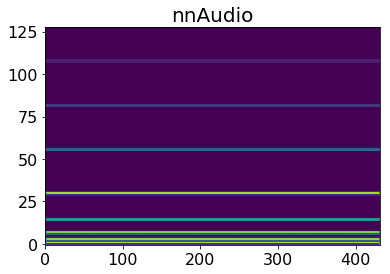

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.imshow(spec[0].cpu().numpy(),aspect='auto', origin='lower')
ax.tick_params(labelsize=16)
ax.set_title('nnAudio', size=20)

# CQT

In [10]:
from librosa.core import note_to_hz

bins = 24 # bins per octave
n_bins = 192
fmin = note_to_hz('C1')
stride = 512

### nnAudio

In [11]:
# Initializing conv1d for CQT 1992 version
spec_layer = Spectrogram.CQT1992v2(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins, norm=1,center=True,
                        pad_mode='reflect')
# Using multiple GPU with this nn.DataParallel
spec_layer = torch.nn.DataParallel(spec_layer)
spec = spec_layer(x)
cqt1992 = spec.cpu().numpy() # saving to RAM for plotting later

CQT kernels created, time used = 0.1701 seconds


In [12]:
# Initializing conv1d for CQT 2010v2 version
spec_layer = Spectrogram.CQT2010v2(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins,
                        pad_mode='reflect', earlydownsample=False)
# Using multiple GPU with this nn.DataParallel
spec_layer = torch.nn.DataParallel(spec_layer)
spec = spec_layer(x)
cqt2010 = spec.cpu().numpy() # saving to RAM for plotting later

Low pass filter created, time used = 0.0009 seconds
num_octave =  8
CQT kernels created, time used = 0.0056 seconds


Text(0.5, 1.0, 'nnAudio 2010')

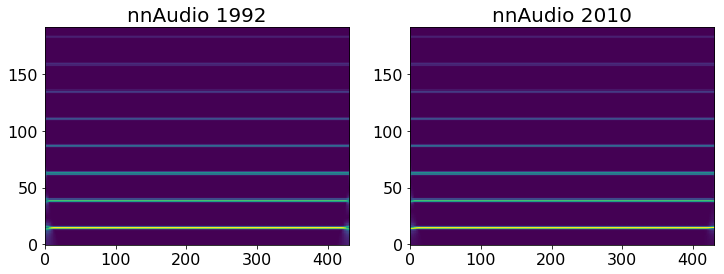

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cqt1992[0],aspect='auto', origin='lower')
ax[0].tick_params(labelsize=16)
ax[0].set_title('nnAudio 1992', size=20)

ax[1].imshow(cqt2010[0], aspect='auto', origin='lower')
ax[1].tick_params(labelsize=16)
ax[1].set_title('nnAudio 2010', size=20)
